In [1]:
import os
import numpy as np
import pandas as pd

import nltk

from utils import *

import matplotlib.pyplot as plt
from IPython.display import IFrame, display

pd.options.display.max_columns = None

### Read

In [2]:
file1 = "data/articles1.csv"
# filenames = ["data/articles{}.csv".format(n) for n in [1,2,3]]

In [3]:
df = pd.read_csv(file1, encoding='utf-8')
# df['content'] = df.content.str.encode('utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
Unnamed: 0     50000 non-null int64
id             50000 non-null int64
title          50000 non-null object
publication    50000 non-null object
author         43694 non-null object
date           50000 non-null object
year           50000 non-null float64
month          50000 non-null float64
url            0 non-null float64
content        50000 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 3.8+ MB


In [4]:
df.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [5]:
df.publication.value_counts()

Breitbart           23781
CNN                 11488
New York Times       7803
Business Insider     6757
Atlantic              171
Name: publication, dtype: int64

#### Wow that feels like a strange skew towards Breitbart (perhaps because they are more prolific?). Will have to keep this in mind whenever considering relative frequencies
> Should I remove some Breitbart stuff to reduce influence of a barely-news news source?

### Gather and preprocess text

In [6]:
# add day to help filter
df['day'] = df.date.map(lambda d: int(d.split('-')[2]))

#### First we need stories from an islamic shooter
Lets try to "find" the two orlando stories now using cosine similarity of TFIDF vectors

In [17]:
orlando_date = (12, 6, 2016)

def get_events_daterange(df, dmy_date, day_range=7):
    day, month, year = dmy_date
    return df[(df.year == year) & (df.month == month) & (df.day >= day) & (df.day < day + day_range)]

df_after_or = get_events_daterange(df, orlando_date)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(docs, max_df=0.95, min_df=2):
    tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, max_df=max_df, min_df=min_df)# max_features=n_features,
    # note: min_df and max_df params: If float, the parameter represents a proportion of documents; if integer, absolute counts.
    tfidf = tfidf_vectorizer.fit_transform(docs)

#     tf_vectorizer = CountVectorizer(tokenizer=tokenize, max_df=0.95, min_df=2)
#     tf = tf_vectorizer.fit_transform(docs)
#     labelled_counts = vec_output_to_df(tf_vectorizer, tf)
    
    return cosine_similarity(tfidf)

In [19]:
stories_after_or = df_to_stringlist(df_after_or)
similarity_after_or = get_cosine_similarity(stories_after_or)

Find similarity to a known orlando story. Here are two such stories--happened 2 and 4 days after the shooting.

In [20]:
# orlando shooting happened on 6/12/2016
df[df.id.isin([20547, 20550])]

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
2941,2941,20547,"Orlando Gunman Attacks Gay Nightclub, Leaving ...",New York Times,Lizette Alvarez and Richard Pérez-Peña,2016-06-14,2016.0,6.0,NaN,"ORLANDO, Fla. — A man who called 911 to pro...",14
2943,2943,20550,Orlando Shooting: What We Know and Don’t Know ...,New York Times,Liam Stack,2016-06-16,2016.0,6.0,NaN,A gunman who claimed allegiance to the Islamic...,16


,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
2943,2943,20550,Orlando Shooting: What We Know and Don’t Know ...,New York Times,Liam Stack,2016-06-16,2016.0,6.0,NaN,A gunman who claimed allegiance to the Islamic...,16


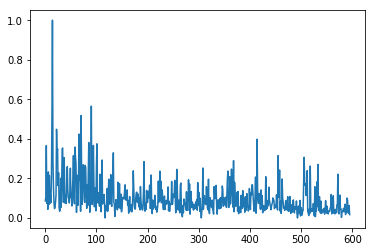

In [21]:
get_idx_from_id = lambda df, sid: df.index.get_loc(df[df.id == sid].index[0])

or_idx = get_idx_from_id(df_after_or, 20550)

# display to be sure
display(df_after_or.iloc[or_idx:or_idx+1])

plt.plot(similarity_after_or[or_idx])
plt.show()

In [26]:
# week_events[tf_similarity[or_idx] > 0.5] # using threshold

# let's get the n closest instead
n_most_similar = 30
filter_n_highest = lambda arr, n_highest: arr.argsort()[-n_highest:][::-1]
likely_or = df_after_or.iloc[filter_n_highest(similarity_after_or[or_idx], n_most_similar)]
likely_or

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
2943,2943,20550,Orlando Shooting: What We Know and Don’t Know ...,New York Times,Liam Stack,2016-06-16,2016.0,6.0,NaN,A gunman who claimed allegiance to the Islamic...,16
6620,6620,24948,Omar Mateen Posted to Facebook Amid Orlando At...,New York Times,"Alan Blinder, Frances Robles and Richard Pérez...",2016-06-17,2016.0,6.0,NaN,"JENSEN BEACH, Fla. — The gunman who committ...",17
5410,5410,23326,Omar Mateen Told Police He’d Strap Bombs to Ho...,New York Times,Frances Robles and Richard Pérez-Peña,2016-06-17,2016.0,6.0,NaN,"ORLANDO, Fla. — Amid the massacre at a gay ...",17
2941,2941,20547,"Orlando Gunman Attacks Gay Nightclub, Leaving ...",New York Times,Lizette Alvarez and Richard Pérez-Peña,2016-06-14,2016.0,6.0,NaN,"ORLANDO, Fla. — A man who called 911 to pro...",14
2955,2955,20563,Obama Says Orlando Gunman Was Probably a Homeg...,New York Times,Julie Hirschfeld Davis,2016-06-14,2016.0,6.0,NaN,WASHINGTON — President Obama said Monday th...,14
5404,5404,23320,"After F.B.I.’s Inquiry Into Omar Mateen, a Foc...",New York Times,Matt Apuzzo and Eric Lichtblau,2016-06-15,2016.0,6.0,NaN,"WASHINGTON — Every day, in F. B. I. offices...",15
35603,36391,55217,"Orlando shooter texted wife during attack, sou...",CNN,Holly Yan,2016-06-16,2016.0,6.0,NaN,(CNN) The Orlando shooter and his wife exchan...,16
6613,6613,24941,Obama Denounces Donald Trump for His ‘Dangerou...,New York Times,Julie Hirschfeld Davis and Matt Flegenheimer,2016-06-15,2016.0,6.0,NaN,WASHINGTON — President Obama angrily denoun...,15
7556,7556,26203,Orlando Shooting Survivors Cope With the Traum...,New York Times,Sheryl Gay Stolberg and Richard Pérez-Peña,2016-06-15,2016.0,6.0,NaN,"ORLANDO, Fla. — With dozens of survivors of...",15
7235,7235,25774,"After Nightclub Massacre, Obama Expresses Outr...",New York Times,Michael D. Shear,2016-06-13,2016.0,6.0,NaN,WASHINGTON — The tableau at the White House...,13


Wow! This actually worked super super well

In [41]:
len(likely_or)

30

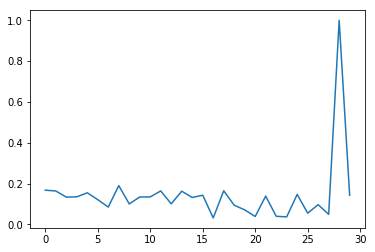

In [43]:
# likely_or[likely_or.id == 26201].content.iloc[0]
cs = get_cosine_similarity(df_to_stringlist(likely_or), max_df=1.0, min_df=1)
print(len(likely_or))
plt.plot(cs[get_idx_from_id(likely_or, 26201)])
plt.show()

In [103]:
from sklearn.cluster import KMeans


def kmeans_split(df):
    docs = df_to_stringlist(df)
    
    tf_vectorizer = CountVectorizer(tokenizer=tokenize)
    tf = tf_vectorizer.fit_transform(docs)
    
    kmeans = KMeans(n_clusters=2).fit(tf)
    
#     print(kmeans.labels_)
#     print(kmeans.predict(tf))
    
    return kmeans.labels_
#     nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(tf)
#     distances, indices = nbrs.kneighbors(tf)

stories_or = likely_or[two_neighbors(likely_or) == 0]
print('ignored stories:')
likely_or[kmeans_split(likely_or) == 1]

ignored stories:


,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
6613,6613,24941,Obama Denounces Donald Trump for His ‘Dangerou...,New York Times,Julie Hirschfeld Davis and Matt Flegenheimer,2016-06-15,2016.0,6.0,NaN,WASHINGTON — President Obama angrily denoun...,15
7235,7235,25774,"After Nightclub Massacre, Obama Expresses Outr...",New York Times,Michael D. Shear,2016-06-13,2016.0,6.0,NaN,WASHINGTON — The tableau at the White House...,13
2788,2788,20387,New Questions Arise Over Sumner Redstone’s Com...,New York Times,Emily Steel,2016-06-14,2016.0,6.0,NaN,The mental competency of the ailing media m...,14
5393,5393,23307,Donald Trump Seizes on Orlando Shooting and Re...,New York Times,Jonathan Martin,2016-06-13,2016.0,6.0,NaN,WASHINGTON — Donald J. Trump on Sunday soug...,13
2967,2967,20575,Donald Trump Responds to Orlando Attack by Exp...,New York Times,Patrick Healy and Thomas Kaplan,2016-06-15,2016.0,6.0,NaN,It was one of George W. Bush’s most viscerally...,15
2957,2957,20565,Donald Trump and Hillary Clinton’s Speeches: W...,New York Times,Nick Corasaniti and Matt Flegenheimer,2016-06-14,2016.0,6.0,NaN,Donald J. Trump addressed the massacre in Orla...,14
2956,2956,20564,"Blaming Muslims After Attack, Donald Trump Tos...",New York Times,Jonathan Martin and Alexander Burns,2016-06-14,2016.0,6.0,NaN,Donald J. Trump left little doubt on Monday th...,14
5383,5383,23295,"Where to, Hillary? How Clinton Is Relying on P...",New York Times,Michael D. Shear and Patrick Healy,2016-06-17,2016.0,6.0,NaN,WASHINGTON — After George W. Bush twice car...,17
2978,2978,20588,Trump Veers From Party Line on Gun Control - T...,New York Times,Ashley Parker and David M. Herszenhorn,2016-06-16,2016.0,6.0,NaN,WASHINGTON — Donald J. Trump said Wednesday...,16
2944,2944,20551,Bernie Sanders Refuses to Concede Nomination t...,New York Times,Yamiche Alcindor,2016-06-13,2016.0,6.0,NaN,Senator Bernie Sanders said on Sunday that he ...,13


Definite improvement, but for the sake of clean data lets pull out the last two unrelated stories

In [62]:
to_remove = [5396,7555]
if np.any([stories_or.index.contains(i) for i in to_remove]):
    stories_or = stories_or.drop(to_remove)

stories_or

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
2943,2943,20550,Orlando Shooting: What We Know and Don’t Know ...,New York Times,Liam Stack,2016-06-16,2016.0,6.0,NaN,A gunman who claimed allegiance to the Islamic...,16
6620,6620,24948,Omar Mateen Posted to Facebook Amid Orlando At...,New York Times,"Alan Blinder, Frances Robles and Richard Pérez...",2016-06-17,2016.0,6.0,NaN,"JENSEN BEACH, Fla. — The gunman who committ...",17
5410,5410,23326,Omar Mateen Told Police He’d Strap Bombs to Ho...,New York Times,Frances Robles and Richard Pérez-Peña,2016-06-17,2016.0,6.0,NaN,"ORLANDO, Fla. — Amid the massacre at a gay ...",17
2941,2941,20547,"Orlando Gunman Attacks Gay Nightclub, Leaving ...",New York Times,Lizette Alvarez and Richard Pérez-Peña,2016-06-14,2016.0,6.0,NaN,"ORLANDO, Fla. — A man who called 911 to pro...",14
2955,2955,20563,Obama Says Orlando Gunman Was Probably a Homeg...,New York Times,Julie Hirschfeld Davis,2016-06-14,2016.0,6.0,NaN,WASHINGTON — President Obama said Monday th...,14
5404,5404,23320,"After F.B.I.’s Inquiry Into Omar Mateen, a Foc...",New York Times,Matt Apuzzo and Eric Lichtblau,2016-06-15,2016.0,6.0,NaN,"WASHINGTON — Every day, in F. B. I. offices...",15
35603,36391,55217,"Orlando shooter texted wife during attack, sou...",CNN,Holly Yan,2016-06-16,2016.0,6.0,NaN,(CNN) The Orlando shooter and his wife exchan...,16
7556,7556,26203,Orlando Shooting Survivors Cope With the Traum...,New York Times,Sheryl Gay Stolberg and Richard Pérez-Peña,2016-06-15,2016.0,6.0,NaN,"ORLANDO, Fla. — With dozens of survivors of...",15
7235,7235,25774,"After Nightclub Massacre, Obama Expresses Outr...",New York Times,Michael D. Shear,2016-06-13,2016.0,6.0,NaN,WASHINGTON — The tableau at the White House...,13
2968,2968,20577,"Held Hostage in an Orlando Restroom, and Playi...",New York Times,Jack Healy and Marc Santora,2016-06-16,2016.0,6.0,NaN,"ORLANDO, Fla. — As the sound of gunfire in ...",16


In [63]:
len(stories_or)

18

Great....

#### Now we need stories from a shooting with a non-islamic-extremist
Lets use the Dallas police shooting on 7/7/2016

In [72]:
def stuff(df, date):
    df_in_range = get_events_daterange(df, date)
    stories = df_to_stringlist(df_in_range)
    cs = get_cosine_similarity(stories)

    return df_in_range, cs

In [87]:
dallas_date = (7,7,2016)
# get_events_daterange(df, dallas_date)
stories_after_dallas, cs_dal = stuff(df, dallas_date)
# stories_dal_pot

In [88]:
dal_idxs = np.where(stories_after_dallas.title.str.contains('Micah'))[0]
stories_after_dallas.iloc[dal_idxs]

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
22911,22915,41662,EXCLUSIVE - New Black Panther Leader: Cop Kill...,Breitbart,Aaron Klein,2016-07-10,2016.0,7.0,NaN,“The fact that Micah just got five of the bast...,10
23043,23047,41795,Dallas Shooter Micah Xavier Johnson Wanted To ...,Breitbart,Michelle Moons,2016-07-08,2016.0,7.0,NaN,One suspect in the assassinations and attacks ...,8
30057,30065,48830,Report: Micah Johnson ’Scrawled a Black Revolu...,Breitbart,Breitbart News,2016-07-10,2016.0,7.0,NaN,advertisement,10


Ugh they are only Breitbart race baiting articles... hopefully this helps tho...

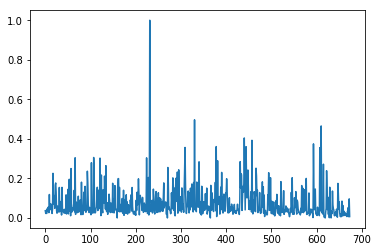

In [89]:
plt.plot(cs_dal[get_idx_from_id(stories_after_dallas, 41795)])
plt.show()

In [96]:
def get_most_similar(df, cs, story_id, n_most_similar=10):
    primary_idx = get_idx_from_id(stories_after_dallas, story_id)
    return df.iloc[filter_n_highest(cs[primary_idx], n_most_similar)]

get_most_similar(stories_after_dallas, cs_dal, 41795, n_most_similar=5)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
23043,23047,41795,Dallas Shooter Micah Xavier Johnson Wanted To ...,Breitbart,Michelle Moons,2016-07-08,2016.0,7.0,NaN,One suspect in the assassinations and attacks ...,8
28739,28747,47508,"5 Police Officers Killed, 6 Wounded by Snipers...",Breitbart,Bob Price and Lana Shadwick,2016-07-07,2016.0,7.0,NaN,Live coverage from Breitbart News of the coord...,7
47647,50777,70510,Texas officials confirm Dallas police shooter ...,Business Insider,Natasha Bertrand,2016-07-09,2016.0,7.0,NaN,’ ’ ’ Texas state officials confirmed that ...,9
36140,37020,55850,"Dallas shooting: 5 officers die, suspect ID’d",CNN,Faith Karimi,2016-07-08,2016.0,7.0,NaN,(CNN) The ambush started with gunshots that k...,8
36157,37040,55870,Dallas police end search for suspicious person,CNN,NaN,2016-07-09,2016.0,7.0,NaN,(CNN) Dallas police officers searched for hou...,9


Again with non-Breitbart seed

In [100]:
likely_dal = get_most_similar(stories_after_dallas, cs_dal, 55850, n_most_similar=30)
likely_dal

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
36140,37020,55850,"Dallas shooting: 5 officers die, suspect ID’d",CNN,Faith Karimi,2016-07-08,2016.0,7.0,NaN,(CNN) The ambush started with gunshots that k...,8
36157,37040,55870,Dallas police end search for suspicious person,CNN,NaN,2016-07-09,2016.0,7.0,NaN,(CNN) Dallas police officers searched for hou...,9
47630,50759,70491,"Multiple police officers shot, at least 5 kill...",Business Insider,NaN,2016-07-08,2016.0,7.0,NaN,’ ’ ’ Multiple police officers were shot an...,8
47647,50777,70510,Texas officials confirm Dallas police shooter ...,Business Insider,Natasha Bertrand,2016-07-09,2016.0,7.0,NaN,’ ’ ’ Texas state officials confirmed that ...,9
6682,6682,25022,"Shootings in Dallas, Minnesota and Baton Rouge...",New York Times,Sewell Chan,2016-07-09,2016.0,7.0,NaN,A week of shocking violence in the United Stat...,9
36145,37026,55856,"Before Dallas, another shooting targeting police",CNN,Evan Perez,2016-07-08,2016.0,7.0,NaN,(CNN) Before the mass shooting of police offi...,8
18661,18663,37404,War on Police Spreads: 3 More Cops Ambushed Ac...,Breitbart,Bob Price,2016-07-08,2016.0,7.0,NaN,Police officers in three different states have...,8
36362,37280,56112,13 days in Baton Rouge,CNN,Joshua Berlinger,2016-07-11,2016.0,7.0,NaN,"(CNN) For the second time in just 13 days, Ba...",11
36194,37082,55912,Dallas police chief: Shooter had larger plans,CNN,Eric Bradner,2016-07-10,2016.0,7.0,NaN,(CNN) The gunman who killed five police offic...,10
5551,5551,23508,Have the Dallas Police Improved? Depends on Wh...,New York Times,John Eligon and Nikole Hannah-Jones,2016-07-13,2016.0,7.0,NaN,DALLAS — When Andre Stubblefield leaves his...,13


In [101]:
likely_dal.publication.value_counts()

CNN                 15
Business Insider     6
New York Times       5
Breitbart            4
Name: publication, dtype: int64

Let's try to remove some of the unrelated stories again. I see more analysis pieces and some police shooting pieces as well, so likely a tougher job

In [108]:
stories_dal = likely_dal[kmeans_split(likely_dal) == 0]
print('ignored stories:')
likely_dal[kmeans_split(likely_dal) == 1]

ignored stories:


,Unnamed: 0,id,title,publication,author,date,year,month,url,content,day
28739,28747,47508,"5 Police Officers Killed, 6 Wounded by Snipers...",Breitbart,Bob Price and Lana Shadwick,2016-07-07,2016.0,7.0,NaN,Live coverage from Breitbart News of the coord...,7


K-means didn't do so well getting rid of the right stories this time....... Will procedd manually for now!

## Analysis

#### Investigation: taking a corpus from each of two shooting events, one with a muslim extremist shooter and one not, how do frequent words compare?
What about the word "terrorist" (absolute or relative to # of words/adjectives in the story)?